Setup Mario


In [3]:
!pip install gym-super-mario-bros nes-py

In [4]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace 
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [5]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [7]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env,SIMPLE_MOVEMENT)

In [8]:
env.action_space

Discrete(7)

In [9]:
# Create a flag - restart or not
done = True

for step in range(100000):
    if done:
        env.reset()
    
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

c:\Users\hosma\anaconda3\envs\gameAI\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\hosma\anaconda3\envs\gameAI\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Preprocess Environment

In [10]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [34]:
# 1. Create the base environment
env = gym_super_mario_bros.make("SuperMarioBros-v0")
# 2. Simplify the controls
env = JoypadSpace(env,SIMPLE_MOVEMENT)
# 3. Grayscale
env =  GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env,4,channels_order="last")

In [56]:
state = env.reset()

In [57]:
state.shape

(1, 240, 256, 4)

In [58]:
state, reward, done, info = env.step([env.action_space.sample()])

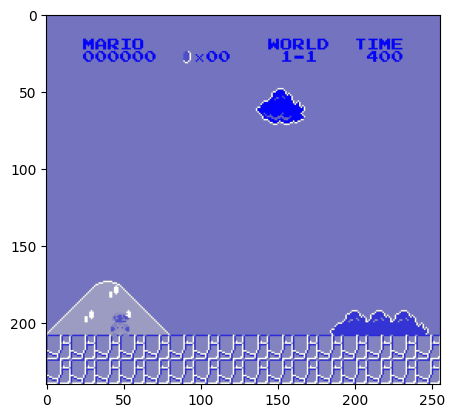

In [59]:
plt.imshow(state[0],"gray")

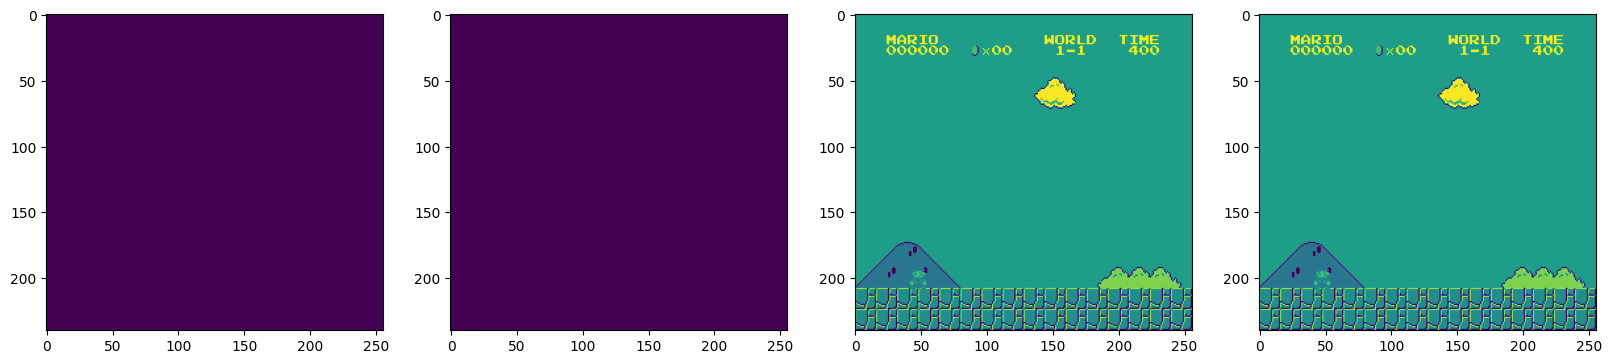

In [62]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

Train the RL Model

In [63]:
# Import os for file path management
import os
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [64]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path,exist_ok=True)
    
    def _on_step(self) :
        
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path,"best_model_{}".format(self.n_calls))
            self.model.save(model_path)

        return True
        

In [65]:
CHECK_POINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [66]:
# Setup model saving callbacks
callback = TrainAndLoggingCallback(check_freq=10000,save_path=CHECK_POINT_DIR)

In [67]:
# This is the AI model started
model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR,learning_rate=0.000001, n_steps=512)

Using cuda device
Wrapping the env in a VecTransposeImage.


In [68]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000,callback=callback)

Logging to ./logs/PPO_1


c:\Users\hosma\anaconda3\envs\gameAI\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 37  |
|    iterations      | 1   |
|    time_elapsed    | 13  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 2             |
|    time_elapsed         | 24            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.1464348e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00138       |
|    learning_rate        | 1e-06         |
|    loss                 | 149           |
|    n_updates            | 10            |
|    policy_gradient_loss | -8.18e-05     |
|    value_loss           | 414           |
-------------------------------------------
-----

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
model.save("model_path")

Test it Out

In [ ]:
model = PPO.load("model_path")

In [ ]:
# Start the game
state = env.reset()
# Loop through the game
while True:
    action, _state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()